# Structure relaxation

This tutorial demonstrates how to relax a structure and calculate an energy-volume curve with only a few commands.

First we need to import a few support functions for creating the structure (`bulk`), the `CPUNEP` calculator and the `relax_structure` function from calorine as well as functionality from `matplotlib` and `pandas` that we will use for plotting.

All models and structures required for running this tutorial notebook can be obtained from [Zenodo](https://zenodo.org/record/10658778).
The files are also available in the `tutorials` folder in the [GitLab repository](https://gitlab.com/materials-modeling/calorine/-/tree/master/tutorials).

In [1]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from calorine.calculators import CPUNEP
from calorine.tools import relax_structure
from matplotlib import pyplot as plt
from pandas import DataFrame

Next we create a structure, set up a `CPUNEP` calculator instance, and attach the latter to the structure.

In [2]:
structure = bulk('PbTe', crystalstructure='rocksalt', a=6.6)
calc = CPUNEP('nep-PbTe.txt')
structure.calc = calc

Now we can relax the structure by calling the `relax_structure` function.
To demonstrate the effect of the relaxation, we print the pressure before and after the relaxation.

In [3]:
pressure = -np.sum(structure.get_stress()[:3]) / 3 / GPa
print(f'pressure before: {pressure:.2f} GPa')

relax_structure(structure)
pressure = -np.sum(structure.get_stress()[:3]) / 3 / GPa
print(f'pressure after:  {pressure:.2f} GPa')

pressure before: 0.68 GPa
pressure after:  0.00 GPa


We can readily calculate the energy-volume curve from 80% to 105% of the equilibrium volume.
To this end, we use again the `relax_structure` function but set the `constant_volume` argument to `True`.
This implies that the volume remains constant during the relaxation while the positions and the (volume constrained) cell metric are allowed to change.
The results are first compiled into a list, which is then converted into a pandas `DataFrame` object.
The latter is not necessary as we could simply use a list but it is often convenient to use `DataFrame` objects when dealing with more complex data sets.

In [4]:
data = []
for volsc in np.arange(0.8, 1.05, 0.01):
    s = structure.copy()
    s.cell *= volsc ** (1 / 3)  # the cubic root converts from volume strain to linear strain
    s.calc = calc
    relax_structure(s, constant_volume=True)
    data.append(dict(volume=s.get_volume() / len(structure),
                     energy=s.get_potential_energy() / len(structure),
                     pressure=-np.sum(s.get_stress()[:3]) / 3 / GPa))
df = DataFrame.from_dict(data)

Finally, we plot the energy-volume curve along with the pressure-volume curve.

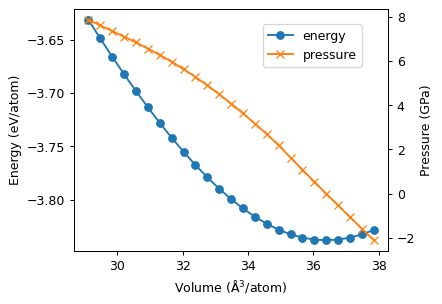

In [5]:
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=90)

ax.plot(df.volume, df.energy, 'o-', label='energy')
ax2 = ax.twinx()
ax2.plot(df.volume, df.pressure, 'x-', color='C1', label='pressure')

ax.set_xlabel('Volume (Å$^3$/atom)')
ax.set_ylabel('Energy (eV/atom)')
ax2.set_ylabel('Pressure (GPa)')

fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85));

## Relaxation with a fixed cell

In some scenarios, it is helpful to keep the cell constant but still relax the atomic configuration. This can be done by setting the `constant_cell` keyword argument.

In [6]:
structure = bulk('PbTe', crystalstructure='rocksalt', a=6.6) 
structure.cell *= 1.1 ** (1 / 3)  # we strain the cell like above
calc = CPUNEP('nep-PbTe.txt')
structure.calc = calc

We save the cell and atomic positions before relaxing.

In [7]:
positions_pre_relax = structure.get_positions()
cell_pre_relax = structure.get_cell()

The structure is then relaxed under the constraint that the cell is unchanged.

In [8]:
relax_structure(structure, constant_cell=True)

Finally, we make sure that the atoms moved but that the cell did not change.

In [9]:
# Make sure that the atoms moved
assert not np.allclose(positions_pre_relax, structure.get_positions())

# And make sure that the cell didn't change
assert np.allclose(cell_pre_relax, structure.get_cell())